In [1]:
#!/usr/bin/env python3

import os
import sys
import numpy as np 
import argparse 
import time 

import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 


from torchvision import datasets, transforms

seed = 7
np.random.seed(seed)
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size =200

n_epochs = 5


def param(nnet, Mb=True):
    """
    Return the number of parameters in nnet
    """
    nelems = sum([param.nelement() for param in nnet.parameters()])

    return nelems / 10**6 if Mb else nelems

In [14]:
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from torch.nn import functional as F

import numpy as np
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
from collections import defaultdict


Num_H = 1600

class dnn_autoencoder(nn.Module):
    def __init__(self,Num_H):
        super(dnn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, Num_H),
            nn.ReLU(True),
            nn.Linear(Num_H, Num_H),
            nn.ReLU(True), nn.BatchNorm1d(Num_H))
        self.decoder = nn.Sequential(
            nn.Linear(Num_H, 28*28), nn.ReLU(True))
        self.name = "DNN_autoencoder"

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [3]:
def test_ae(model, criterion, optimizer, test_loader):
    # monitor training loss
    test_loss = 0.0
    for data in test_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)
        test_loss += loss.item()*images.size(0)

    test_loss = test_loss/len(test_loader)
    print('Val. Loss: {:.6f}'.format( 
        test_loss
        ))
    return test_loss

def train_ae(model, n_epochs, criterion, optimizer, train_loader, test_loader, w_name = "19_dnn_ae"):
    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0
        test_loss = 0.0
        ###################
        # train the model #
        ###################
        for data in train_loader:
            # _ stands in for labels, here
            images, _ = data
            # flatten images
            images = images.view(images.size(0), -1)
            images = images.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs, images)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*images.size(0)

        # print avg training statistics 
        train_loss = train_loss/len(train_loader)
        test_loss = test_ae(model, criterion, optimizer, test_loader)
        print('Epoch: {} \t Training Loss: {:.6f} \t Val. Loss: {:.6f}'.format(
            epoch, 
            train_loss, test_loss
            ))

    torch.save(model.state_dict(), "model_weights/" + w_name + ".pt")
    return model, test_loss



In [9]:



### get data
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)
# Create training and test dataloaders

seed = 7
np.random.seed(seed)
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)


lr = 0.0001
# specify loss function

# number of epochs to train the model
n_epochs = 10



100.0%

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz


111.0%

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


100.0%

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


159.1%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_res(model):
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = dataiter.next()

    images_flatten = images.view(images.size(0), -1)
    # get sample outputs
    output = model(images_flatten.to(device))
    # prep images for display
    images = images.numpy()

    # output is resized into a batch of images
    output = output.view(batch_size, 1, 28, 28)
    # use detach when it's an output that requires_grad
    output = output.cpu().detach().numpy()

    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

In [13]:
# model_ae = autoencoder(800).cuda()
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
# model_ae.parameters(), lr=1e-4, weight_decay=1e-5)

# model_ae = train_ae(model_ae, 10, criterion, optimizer, train_loader)
# loss = train_ae(model_ae, criterion, optimizer, test_loader)

# print("DNN MSE Results, N = 800")
# print("DNN MSE", param(model_ae),"MB", ", Val. loss = ", loss)
# show_res(model_ae)

# DNN AE Results

Val. Loss: 0.947990
Epoch: 1 	 Training Loss: 1.129190 	 Val. Loss: 0.947990
Val. Loss: 0.863042
Epoch: 2 	 Training Loss: 0.884232 	 Val. Loss: 0.863042
Val. Loss: 0.816838
Epoch: 3 	 Training Loss: 0.822396 	 Val. Loss: 0.816838
Val. Loss: 0.779737
Epoch: 4 	 Training Loss: 0.781993 	 Val. Loss: 0.779737
Val. Loss: 0.750708
Epoch: 5 	 Training Loss: 0.751836 	 Val. Loss: 0.750708
Val. Loss: 0.727829
Epoch: 6 	 Training Loss: 0.728374 	 Val. Loss: 0.727829
Val. Loss: 0.712006
Epoch: 7 	 Training Loss: 0.709494 	 Val. Loss: 0.712006
Val. Loss: 0.695485
Epoch: 8 	 Training Loss: 0.694704 	 Val. Loss: 0.695485
Val. Loss: 0.694835
Epoch: 9 	 Training Loss: 0.683656 	 Val. Loss: 0.694835
Val. Loss: 0.683193
Epoch: 10 	 Training Loss: 0.675756 	 Val. Loss: 0.683193
DNN MAE Results, N =  800
DNN MAE 1.896784 MB , Val. loss =  0.6831931135803461


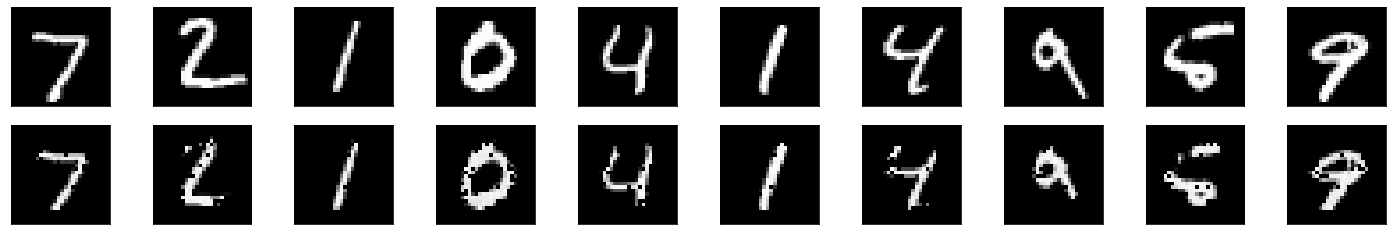

In [17]:
Num_H = 800

model_ae = dnn_autoencoder(Num_H).cuda()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(
model_ae.parameters(), lr=1e-4)

model_ae, val_loss = train_ae(model_ae, 10, criterion, optimizer, train_loader, test_loader, w_name = "dnn_ae"+str(Num_H) )

print("DNN MAE Results, N = ", Num_H )
print("DNN MAE", param(model_ae),"MB", ", Val. loss = ", val_loss)
show_res(model_ae)

Val. Loss: 2.766170
Epoch: 1 	 Training Loss: 3.375779 	 Val. Loss: 2.766170
Val. Loss: 2.566648
Epoch: 2 	 Training Loss: 2.609786 	 Val. Loss: 2.566648
Val. Loss: 2.559029
Epoch: 3 	 Training Loss: 2.571780 	 Val. Loss: 2.559029
Val. Loss: 2.553693
Epoch: 4 	 Training Loss: 2.566673 	 Val. Loss: 2.553693
Val. Loss: 2.550729
Epoch: 5 	 Training Loss: 2.561810 	 Val. Loss: 2.550729
Val. Loss: 2.547381
Epoch: 6 	 Training Loss: 2.558465 	 Val. Loss: 2.547381
Val. Loss: 2.546571
Epoch: 7 	 Training Loss: 2.555389 	 Val. Loss: 2.546571
Val. Loss: 2.544211
Epoch: 8 	 Training Loss: 2.553681 	 Val. Loss: 2.544211
Val. Loss: 2.543738
Epoch: 9 	 Training Loss: 2.551948 	 Val. Loss: 2.543738
Val. Loss: 2.543075
Epoch: 10 	 Training Loss: 2.551100 	 Val. Loss: 2.543075
DNN MAE Results, N = 800
DNN MAE 1.896784 MB , Val. loss =  2.5430746585130692


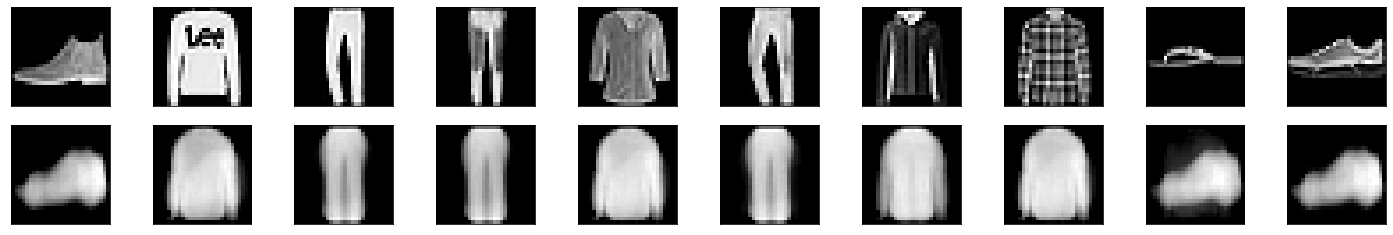

Val. Loss: 2.675808
Epoch: 1 	 Training Loss: 3.304555 	 Val. Loss: 2.675808
Val. Loss: 2.563481
Epoch: 2 	 Training Loss: 2.591452 	 Val. Loss: 2.563481
Val. Loss: 2.555212
Epoch: 3 	 Training Loss: 2.568410 	 Val. Loss: 2.555212
Val. Loss: 2.551734
Epoch: 4 	 Training Loss: 2.563192 	 Val. Loss: 2.551734
Val. Loss: 2.549986
Epoch: 5 	 Training Loss: 2.559692 	 Val. Loss: 2.549986
Val. Loss: 2.549292
Epoch: 6 	 Training Loss: 2.558193 	 Val. Loss: 2.549292
Val. Loss: 2.546907
Epoch: 7 	 Training Loss: 2.555917 	 Val. Loss: 2.546907
Val. Loss: 2.546243
Epoch: 8 	 Training Loss: 2.554829 	 Val. Loss: 2.546243
Val. Loss: 2.545811
Epoch: 9 	 Training Loss: 2.554041 	 Val. Loss: 2.545811
Val. Loss: 2.545305
Epoch: 10 	 Training Loss: 2.553579 	 Val. Loss: 2.545305
DNN MAE Results, N = 900
DNN MAE 2.223784 MB , Val. loss =  2.545305372476578


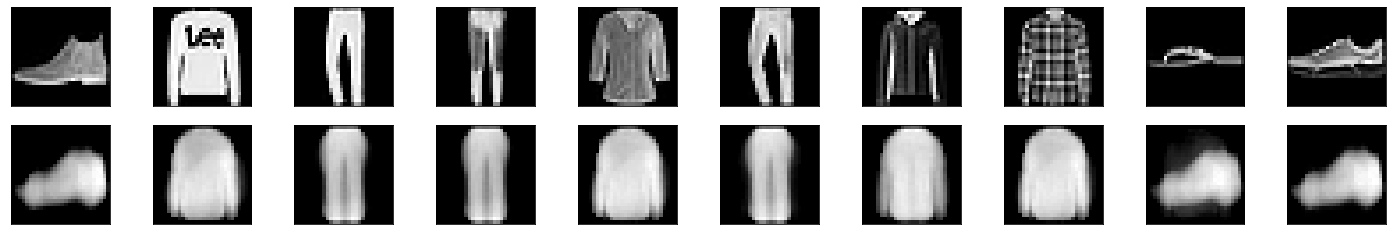

Val. Loss: 2.648735
Epoch: 1 	 Training Loss: 3.262181 	 Val. Loss: 2.648735
Val. Loss: 2.565710
Epoch: 2 	 Training Loss: 2.597528 	 Val. Loss: 2.565710
Val. Loss: 2.556854
Epoch: 3 	 Training Loss: 2.570312 	 Val. Loss: 2.556854
Val. Loss: 2.553126
Epoch: 4 	 Training Loss: 2.565174 	 Val. Loss: 2.553126
Val. Loss: 2.550376
Epoch: 5 	 Training Loss: 2.561414 	 Val. Loss: 2.550376
Val. Loss: 2.549006
Epoch: 6 	 Training Loss: 2.558316 	 Val. Loss: 2.549006


KeyboardInterrupt: 

In [10]:
for Num_H in [800, 900, 1000, 1100, 1600, 2400]:

    model_ae = dnn_autoencoder(Num_H).cuda()
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(
    model_ae.parameters(), lr=1e-4, weight_decay=0.01)

    model_ae , val_loss = train_ae(model_ae, 10, criterion, optimizer, train_loader, test_loader, w_name = "dnn_ae"+str(Num_H) )


    print("DNN MAE Results, N =", Num_H)
    print("DNN MAE", param(model_ae),"MB", ", Val. loss = ", val_loss)
    show_res(model_ae)

In [15]:
val_loss_book = []
para_book = []

Val. Loss: 3.307107
Epoch: 1 	 Training Loss: 4.173907 	 Val. Loss: 3.307107
Val. Loss: 2.746927
Epoch: 2 	 Training Loss: 2.979766 	 Val. Loss: 2.746927
Val. Loss: 2.566381
Epoch: 3 	 Training Loss: 2.638472 	 Val. Loss: 2.566381
Val. Loss: 2.456396
Epoch: 4 	 Training Loss: 2.502857 	 Val. Loss: 2.456396
Val. Loss: 2.378345
Epoch: 5 	 Training Loss: 2.412952 	 Val. Loss: 2.378345
Val. Loss: 2.334711
Epoch: 6 	 Training Loss: 2.351918 	 Val. Loss: 2.334711
Val. Loss: 2.293601
Epoch: 7 	 Training Loss: 2.307365 	 Val. Loss: 2.293601
Val. Loss: 2.250067
Epoch: 8 	 Training Loss: 2.265771 	 Val. Loss: 2.250067
Val. Loss: 2.224897
Epoch: 9 	 Training Loss: 2.232332 	 Val. Loss: 2.224897
Val. Loss: 2.207295
Epoch: 10 	 Training Loss: 2.208488 	 Val. Loss: 2.207295
DNN MAE Results, N = 10
--- DNN MAE 0.016604 MB , Val. loss =  2.20729487746954


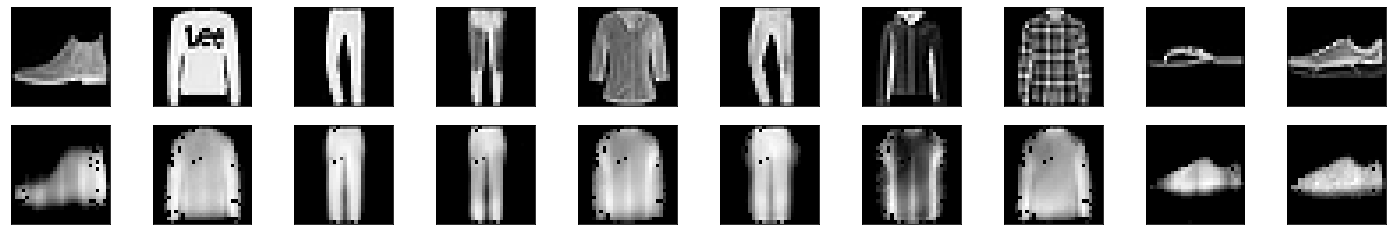

Val. Loss: 1.802667
Epoch: 1 	 Training Loss: 2.539020 	 Val. Loss: 1.802667
Val. Loss: 1.587419
Epoch: 2 	 Training Loss: 1.675901 	 Val. Loss: 1.587419
Val. Loss: 1.481012
Epoch: 3 	 Training Loss: 1.519269 	 Val. Loss: 1.481012
Val. Loss: 1.414303
Epoch: 4 	 Training Loss: 1.433043 	 Val. Loss: 1.414303
Val. Loss: 1.369082
Epoch: 5 	 Training Loss: 1.377657 	 Val. Loss: 1.369082
Val. Loss: 1.335293
Epoch: 6 	 Training Loss: 1.338506 	 Val. Loss: 1.335293
Val. Loss: 1.311865
Epoch: 7 	 Training Loss: 1.309025 	 Val. Loss: 1.311865
Val. Loss: 1.293790
Epoch: 8 	 Training Loss: 1.287887 	 Val. Loss: 1.293790
Val. Loss: 1.279565
Epoch: 9 	 Training Loss: 1.271404 	 Val. Loss: 1.279565
Val. Loss: 1.266877
Epoch: 10 	 Training Loss: 1.257390 	 Val. Loss: 1.266877
DNN MAE Results, N = 100
--- DNN MAE 0.167984 MB , Val. loss =  1.2668773177266122


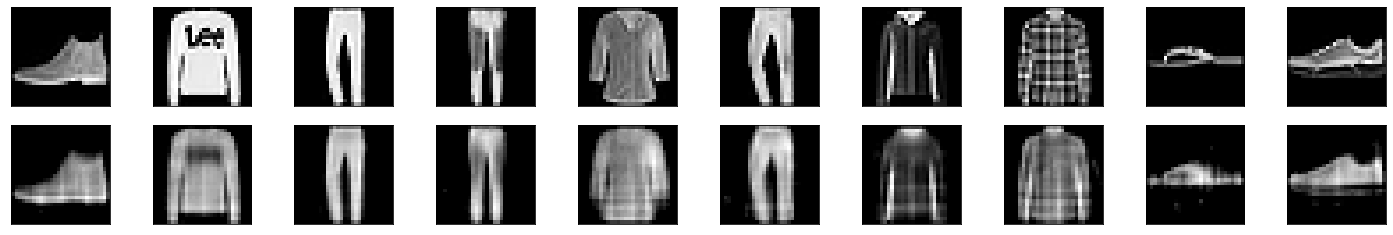

Val. Loss: 1.545485
Epoch: 1 	 Training Loss: 2.162352 	 Val. Loss: 1.545485
Val. Loss: 1.345407
Epoch: 2 	 Training Loss: 1.416981 	 Val. Loss: 1.345407
Val. Loss: 1.258443
Epoch: 3 	 Training Loss: 1.284846 	 Val. Loss: 1.258443
Val. Loss: 1.205564
Epoch: 4 	 Training Loss: 1.214771 	 Val. Loss: 1.205564
Val. Loss: 1.170282
Epoch: 5 	 Training Loss: 1.169805 	 Val. Loss: 1.170282
Val. Loss: 1.143665
Epoch: 6 	 Training Loss: 1.137846 	 Val. Loss: 1.143665
Val. Loss: 1.123259
Epoch: 7 	 Training Loss: 1.113473 	 Val. Loss: 1.123259
Val. Loss: 1.106072
Epoch: 8 	 Training Loss: 1.094051 	 Val. Loss: 1.106072
Val. Loss: 1.092125
Epoch: 9 	 Training Loss: 1.077543 	 Val. Loss: 1.092125
Val. Loss: 1.081640
Epoch: 10 	 Training Loss: 1.063405 	 Val. Loss: 1.081640
DNN MAE Results, N = 200
--- DNN MAE 0.355184 MB , Val. loss =  1.081640475988388


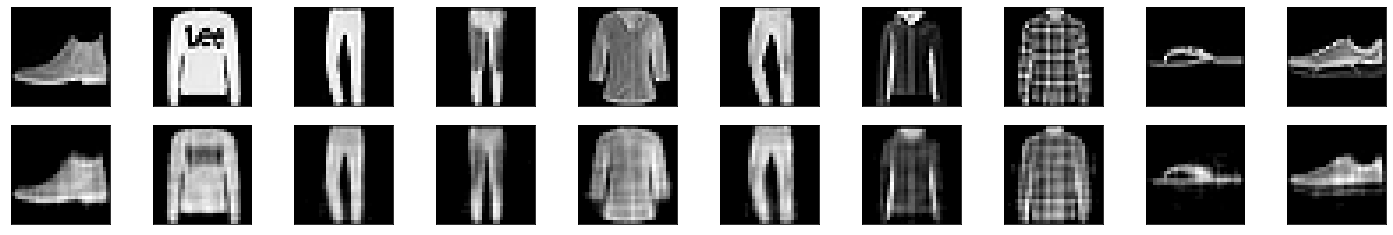

Val. Loss: 1.434021
Epoch: 1 	 Training Loss: 1.996316 	 Val. Loss: 1.434021
Val. Loss: 1.250018
Epoch: 2 	 Training Loss: 1.317398 	 Val. Loss: 1.250018
Val. Loss: 1.165731
Epoch: 3 	 Training Loss: 1.190317 	 Val. Loss: 1.165731
Val. Loss: 1.114462
Epoch: 4 	 Training Loss: 1.122276 	 Val. Loss: 1.114462
Val. Loss: 1.086043
Epoch: 5 	 Training Loss: 1.078103 	 Val. Loss: 1.086043
Val. Loss: 1.054895
Epoch: 6 	 Training Loss: 1.046204 	 Val. Loss: 1.054895
Val. Loss: 1.038773
Epoch: 7 	 Training Loss: 1.021493 	 Val. Loss: 1.038773
Val. Loss: 1.019944
Epoch: 8 	 Training Loss: 1.001819 	 Val. Loss: 1.019944
Val. Loss: 1.005848
Epoch: 9 	 Training Loss: 0.985279 	 Val. Loss: 1.005848
Val. Loss: 0.994024
Epoch: 10 	 Training Loss: 0.970837 	 Val. Loss: 0.994024
DNN MAE Results, N = 300
--- DNN MAE 0.562384 MB , Val. loss =  0.9940236170589923


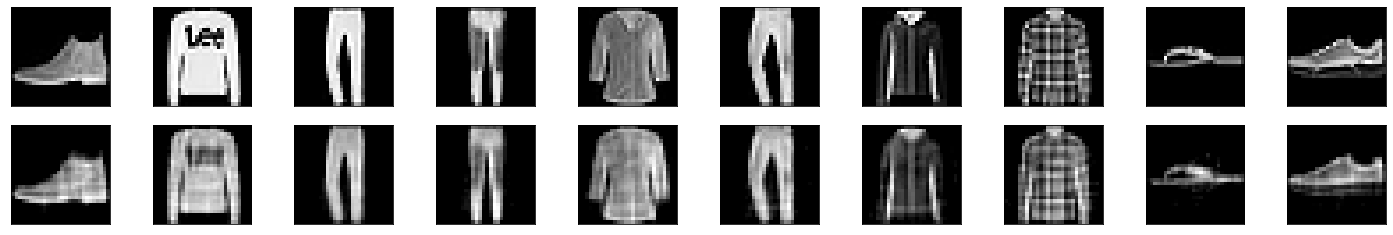

Val. Loss: 1.349019
Epoch: 1 	 Training Loss: 1.871878 	 Val. Loss: 1.349019
Val. Loss: 1.178479
Epoch: 2 	 Training Loss: 1.237197 	 Val. Loss: 1.178479
Val. Loss: 1.097586
Epoch: 3 	 Training Loss: 1.118216 	 Val. Loss: 1.097586
Val. Loss: 1.050958
Epoch: 4 	 Training Loss: 1.053506 	 Val. Loss: 1.050958
Val. Loss: 1.018922
Epoch: 5 	 Training Loss: 1.011266 	 Val. Loss: 1.018922
Val. Loss: 0.994615
Epoch: 6 	 Training Loss: 0.980898 	 Val. Loss: 0.994615
Val. Loss: 0.976400
Epoch: 7 	 Training Loss: 0.956744 	 Val. Loss: 0.976400
Val. Loss: 0.960232
Epoch: 8 	 Training Loss: 0.937341 	 Val. Loss: 0.960232
Val. Loss: 0.947493
Epoch: 9 	 Training Loss: 0.920825 	 Val. Loss: 0.947493
Val. Loss: 0.935724
Epoch: 10 	 Training Loss: 0.906839 	 Val. Loss: 0.935724
DNN MAE Results, N = 400
--- DNN MAE 0.789584 MB , Val. loss =  0.9357244893908501


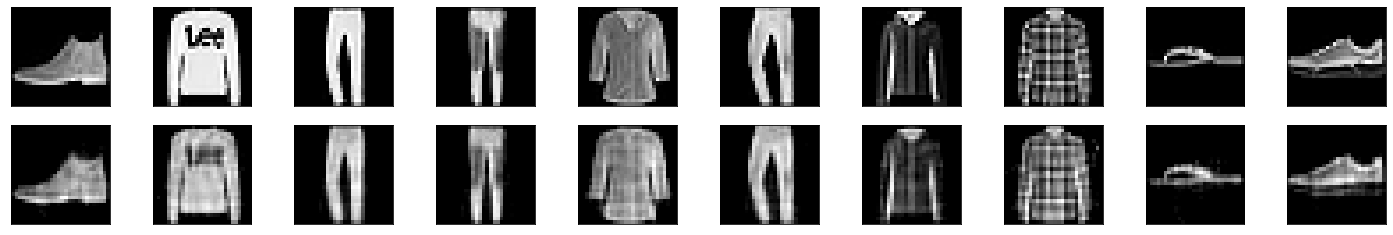

Val. Loss: 1.265601
Epoch: 1 	 Training Loss: 1.754790 	 Val. Loss: 1.265601
Val. Loss: 1.111881
Epoch: 2 	 Training Loss: 1.163144 	 Val. Loss: 1.111881
Val. Loss: 1.037428
Epoch: 3 	 Training Loss: 1.053343 	 Val. Loss: 1.037428
Val. Loss: 0.993253
Epoch: 4 	 Training Loss: 0.993555 	 Val. Loss: 0.993253
Val. Loss: 0.963605
Epoch: 5 	 Training Loss: 0.954372 	 Val. Loss: 0.963605
Val. Loss: 0.942547
Epoch: 6 	 Training Loss: 0.925832 	 Val. Loss: 0.942547
Val. Loss: 0.925684
Epoch: 7 	 Training Loss: 0.903239 	 Val. Loss: 0.925684
Val. Loss: 0.911817
Epoch: 8 	 Training Loss: 0.884768 	 Val. Loss: 0.911817
Val. Loss: 0.898788
Epoch: 9 	 Training Loss: 0.869564 	 Val. Loss: 0.898788
Val. Loss: 0.889495
Epoch: 10 	 Training Loss: 0.856416 	 Val. Loss: 0.889495
DNN MAE Results, N = 500
--- DNN MAE 1.036784 MB , Val. loss =  0.8894951892644167


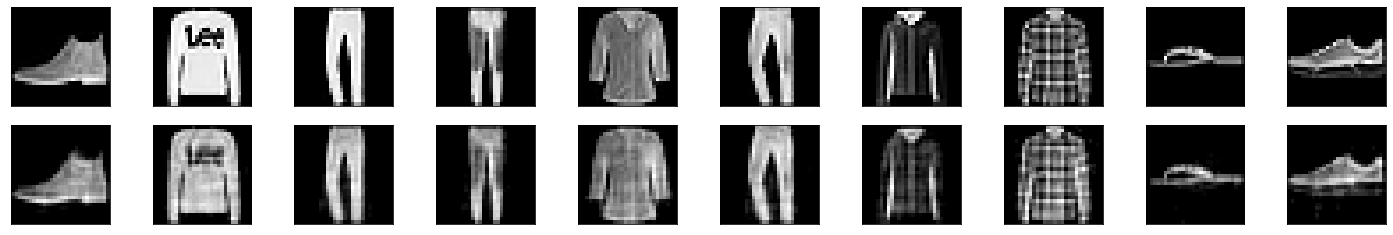

Val. Loss: 1.095122
Epoch: 1 	 Training Loss: 1.507110 	 Val. Loss: 1.095122
Val. Loss: 0.958423
Epoch: 2 	 Training Loss: 1.000482 	 Val. Loss: 0.958423
Val. Loss: 0.898711
Epoch: 3 	 Training Loss: 0.906175 	 Val. Loss: 0.898711
Val. Loss: 0.867093
Epoch: 4 	 Training Loss: 0.854191 	 Val. Loss: 0.867093
Val. Loss: 0.842477
Epoch: 5 	 Training Loss: 0.819387 	 Val. Loss: 0.842477
Val. Loss: 0.820923
Epoch: 6 	 Training Loss: 0.792187 	 Val. Loss: 0.820923
Val. Loss: 0.806112
Epoch: 7 	 Training Loss: 0.771165 	 Val. Loss: 0.806112
Val. Loss: 0.797469
Epoch: 8 	 Training Loss: 0.753612 	 Val. Loss: 0.797469
Val. Loss: 0.784774
Epoch: 9 	 Training Loss: 0.738187 	 Val. Loss: 0.784774
Val. Loss: 0.772972
Epoch: 10 	 Training Loss: 0.725110 	 Val. Loss: 0.772972
DNN MAE Results, N = 1000
--- DNN MAE 2.572784 MB , Val. loss =  0.7729716116189956


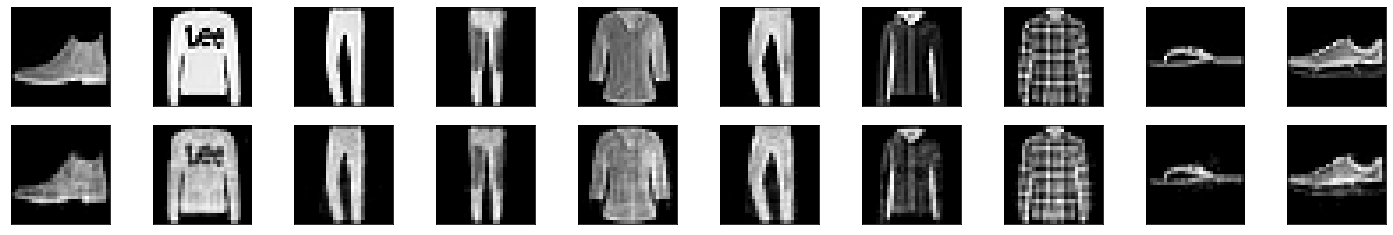

In [16]:
for Num_H in [10, 100, 200, 300, 400, 500, 1000]:

    model_ae = dnn_autoencoder(Num_H).cuda()
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(
    model_ae.parameters(), lr=1e-4)

    model_ae , val_loss = train_ae(model_ae, 10, criterion, optimizer, train_loader, test_loader, w_name = "ann_ae"+str(Num_H) )
    val_loss_book.append(val_loss)

    print("DNN MAE Results, N =", Num_H)
    print("--- DNN MAE", param(model_ae),"MB", ", Val. loss = ", val_loss)
    para_book.append(param(model_ae))
    show_res(model_ae)

Val. Loss: 1.442853
Epoch: 1 	 Training Loss: 1.703447 	 Val. Loss: 1.442853
Val. Loss: 1.300963
Epoch: 2 	 Training Loss: 1.343454 	 Val. Loss: 1.300963
Val. Loss: 1.221615
Epoch: 3 	 Training Loss: 1.241958 	 Val. Loss: 1.221615
Val. Loss: 1.172041
Epoch: 4 	 Training Loss: 1.183172 	 Val. Loss: 1.172041
Val. Loss: 1.143081
Epoch: 5 	 Training Loss: 1.141187 	 Val. Loss: 1.143081
Val. Loss: 1.129343
Epoch: 6 	 Training Loss: 1.109182 	 Val. Loss: 1.129343
Val. Loss: 1.092001
Epoch: 7 	 Training Loss: 1.084128 	 Val. Loss: 1.092001
Val. Loss: 1.083861
Epoch: 8 	 Training Loss: 1.062682 	 Val. Loss: 1.083861
Val. Loss: 1.074300
Epoch: 9 	 Training Loss: 1.046249 	 Val. Loss: 1.074300
Val. Loss: 1.073311
Epoch: 10 	 Training Loss: 1.032458 	 Val. Loss: 1.073311
DNN MAE Results, N = 1600
--- DNN MAE 5.072784 MB , Val. loss =  1.0733111904561519


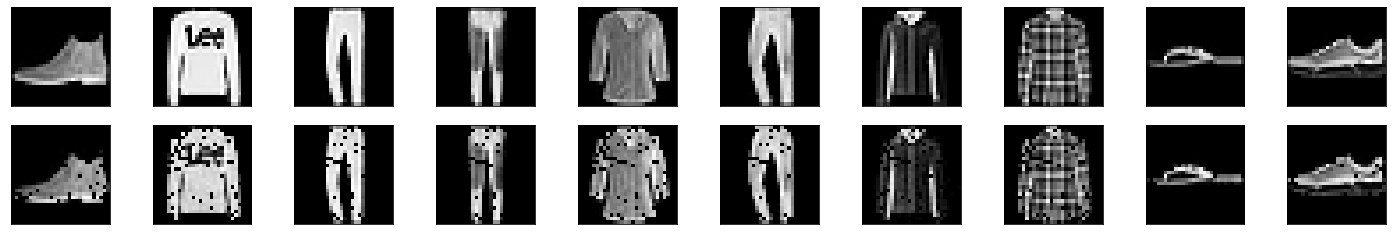

Val. Loss: 1.522878
Epoch: 1 	 Training Loss: 1.791111 	 Val. Loss: 1.522878
Val. Loss: 1.400230
Epoch: 2 	 Training Loss: 1.437596 	 Val. Loss: 1.400230
Val. Loss: 1.354139
Epoch: 3 	 Training Loss: 1.350504 	 Val. Loss: 1.354139
Val. Loss: 1.293391
Epoch: 4 	 Training Loss: 1.298451 	 Val. Loss: 1.293391
Val. Loss: 1.322349
Epoch: 5 	 Training Loss: 1.264791 	 Val. Loss: 1.322349
Val. Loss: 1.276247
Epoch: 6 	 Training Loss: 1.241561 	 Val. Loss: 1.276247
Val. Loss: 1.248153
Epoch: 7 	 Training Loss: 1.223335 	 Val. Loss: 1.248153
Val. Loss: 1.227042
Epoch: 8 	 Training Loss: 1.210407 	 Val. Loss: 1.227042
Val. Loss: 1.224718
Epoch: 9 	 Training Loss: 1.199832 	 Val. Loss: 1.224718
Val. Loss: 1.256662
Epoch: 10 	 Training Loss: 1.193062 	 Val. Loss: 1.256662
DNN MAE Results, N = 2400
--- DNN MAE 9.528784 MB , Val. loss =  1.2566615802049637


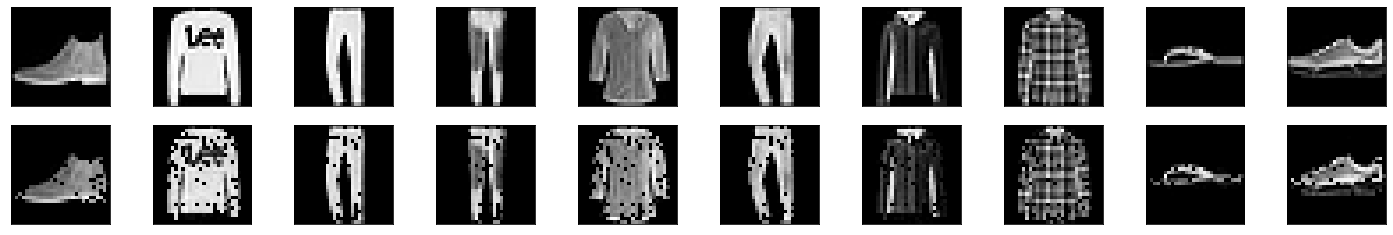

In [13]:
for Num_H in [1600, 2400]:

    model_ae = dnn_autoencoder(Num_H).cuda()
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(
    model_ae.parameters(), lr=1e-4)

    model_ae , val_loss = train_ae(model_ae, 10, criterion, optimizer, train_loader, test_loader, w_name = "ann_ae"+str(Num_H) )
    val_loss_book.append(val_loss)

    print("DNN MAE Results, N =", Num_H)
    print("--- DNN MAE", param(model_ae),"MB", ", Val. loss = ", val_loss)
    para_book.append(param(model_ae))
    show_res(model_ae)

In [17]:
val_loss_book

[2.20729487746954,
 1.2668773177266122,
 1.081640475988388,
 0.9940236170589923,
 0.9357244893908501,
 0.8894951892644167,
 0.7729716116189956]